# Fine-Tuning P.1203 Model

# ITU-T P.1203

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
from itu_p1203_new import P1203Standalone
from itu_p1203_new import P1203Pq
from itu_p1203_new import P1203Pa
from itu_p1203_new import P1203Pv
from itertools import permutations

import json


In [ ]:
f = open("./mode0.json")
input_data = json.load(f)
input_data

In [120]:
bitratesMbps = {
    'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
    'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
    'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
    'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
}

resolution_map = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

In [121]:
p1203_results = {
    'object': [],
    'qual': [],
    'bitrate': [],
    'p1203_qoe': []
}

for video in list(bitratesMbps.keys()):
    bitrates = list(bitratesMbps[video].values())
    qualities = list(bitratesMbps[video].keys())
    
    for bitrate, quality in zip(bitrates, qualities):
        p1203_results['object'].append(video)
        p1203_results['qual'].append(quality)
        p1203_results['bitrate'].append(bitrate)

        input_data['I13']['segments'][0]['bitrate'] = bitrate
        input_data['I13']['segments'][0]['resolution'] = resolution_map[quality]
        # print(input_data)
        p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

# p1203_results

In [ ]:
p1203_df = pd.DataFrame.from_dict(p1203_results)
p1203_df

In [ ]:
p1203_df_1 = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
grouped_p1203_qoe = p1203_df_1.groupby(['object', 'qual'])
grouped_p1203_qoe = grouped_p1203_qoe.mean()
grouped_p1203_qoe


In [ ]:
p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])
p1203_qoe

In [ ]:
import pandas as pd
import numpy as np
# get input data
ground_truth_df = pd.read_csv('./results/individual_opinion_score_vpcc.csv')
ground_truth_df

In [ ]:
ground_truth_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_df.objects.str.split('_', expand=True)
#df['object'] = df['object'].str.lower()
ground_truth_df['rate_scaled'] = ground_truth_df['rate'] # no need to scale it since this time we took 1-5 results
ground_truth_df

In [127]:
ground_truth_df = ground_truth_df.loc[ground_truth_df['object'].isin(['BlueSpin', 'CasualSquat'])]
grouped_ground_truth = ground_truth_df.groupby(['object', 'qual'])
grouped_ground_truth = grouped_ground_truth.mean(numeric_only=True)

In [ ]:
qoe_ground_truth = list(grouped_ground_truth['rate'])
qoe_ground_truth

In [ ]:
plt.scatter(qoe_ground_truth, p1203_qoe)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("P1203 Mode 0")

In [ ]:
#import seaborn as sns
df_correlation = pd.DataFrame({'Ground truth': qoe_ground_truth,
                              'P.1203': p1203_qoe})

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_spearman_1203_1080p.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_pearson_1203_1080p.pdf")
plt.show()



# P1203.1 Pv coefficients updates


In [131]:
# Quant(a1, a2, a3, a4) = a1 + a2*ln(a3+ln(bitrate) + ln(br*br/(codRes*fr) + a4))

# MOSq(q1, q2, q3) = q1 + q2*exp(q3*Quant)
# MOSq = max(min(MOSq, 5), 1)

# Dq = max(min(100 - RfromMOS(MOSq), 100), 0)

# MOSfromR:
#     MOS = MOS_min + (MOS_max - MOS_min) * R/100 + R*(R-60)(100-R)*0.000007
#     MOS = min(MOS_max, max(MOS, MOS_min))
#     Calculate MOSfromR, R from 0 -> 100, step 0.25

In [132]:
from functools import lru_cache
from itertools import permutations
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itu_p1203_new import P1203Standalone
from itu_p1203_new import P1203Pv


In [133]:
f = open("./mode0.json")
input_data = json.load(f)
# input_data

In [ ]:
ground_truth_qoe_df = pd.read_csv('./results/individual_opinion_score_vpcc.csv')
ground_truth_qoe_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_qoe_df.objects.str.split('_', expand=True)
ground_truth_qoe_df['rate_scaled'] = ground_truth_qoe_df['rate']

ground_truth_qoe_df

In [ ]:
ground_truth_qoe_df = ground_truth_qoe_df[['object', 'qual', 'rate_scaled']]
ground_truth_qoe_df

In [136]:
# remove outliers using boxplot method
vpcc_group_columns = ['object', 'qual']
configurations = ground_truth_qoe_df.groupby(vpcc_group_columns)

def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)["rate_scaled"]
    q3 = frame.quantile(0.75, numeric_only=True)["rate_scaled"]
    
    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    filtered = (frame["rate_scaled"] >= fence_low) & (frame["rate_scaled"] <= fence_high)
    return frame.loc[filtered]

# for each configuration, filter outliers
df_vpcc_filtered = None
for _, frame in configurations:
    #print(boxplot_outlier_filter(frame))
    df_vpcc_filtered = pd.concat([df_vpcc_filtered, boxplot_outlier_filter(frame)], axis=0)

df_vpcc_filtered = df_vpcc_filtered.reset_index(drop=True)
# groups = df_vpcc_filtered.groupby(vpcc_group_columns)


In [ ]:
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['BlueSpin', 'CasualSquat'])]
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'qual']).aggregate(lambda x: tuple(x))
ground_truth_qoe_grouped_df

In [138]:
bitratesMbps = {
    'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
    'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
    'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
    'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
}

resolution_map = {
    'r01': '640x360', # worse than 480p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

In [139]:
def calculate_p1203(coeffs):

    p1203_results = {
        'object': [],
        'qual': [],
        'bitrate': [],
        'p1203_qoe': []
    }

    for video in list(bitratesMbps.keys()):
        bitrates = list(bitratesMbps[video].values())
        qualities = list(bitratesMbps[video].keys())
        
        for bitrate, quality in zip(bitrates, qualities):
            p1203_results['object'].append(video)
            p1203_results['qual'].append(quality)
            p1203_results['bitrate'].append(bitrate)

            input_data['I13']['segments'][0]['bitrate'] = bitrate*1000
            input_data['I13']['segments'][0]['resolution'] = resolution_map[quality]

            #print("input data")
            #print(input_data)
            
            qoe_p1203 = P1203Standalone(input_data, coeffs=coeffs).calculate_complete()['O46']
            
            p1203_results['p1203_qoe'].append(qoe_p1203)

    return p1203_results

In [140]:
def calculate_rmse(p1203_results, mos):
    joined_qoe = p1203_results.join(mos)
    rmse_arr = []
    #print("joined_qoe")
    #print(joined_qoe)

    for idx in np.arange(joined_qoe.shape[0]):
        
        #print("joined_qoe.shape[0]")
        #print(joined_qoe.shape[0])
        targets = joined_qoe.iloc[idx,:]['rate_scaled']
        #print("targets")
        #print(targets)
        #print(len(targets))
        predictions = np.full(len(targets), joined_qoe.loc[joined_qoe.index[idx], 'p1203_qoe'])
        #print("predictions")
        #print(predictions)
        #print(len(predictions))
        rmse_arr.append(np.sqrt(np.mean((predictions-targets)**2)))
        #print("rmse_arr")
        #print(rmse_arr)
    
    return np.average(rmse_arr)


In [141]:
from datetime import datetime

_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

def finetune_coeffs():
    min_rmse = sys.float_info.max
    optimized_coeffs = _COEFFS
    optimized_p1203_qoe  =[]

    # for _COEFFS['u1'] in np.arange(50,100):
    #     for _COEFFS['u2'] in np.arange(1):
            # for _COEFFS['t1'] in np.arange(1):
            #     for _COEFFS['t2'] in np.arange(1):
            #         for _COEFFS['t3'] in np.arange(1):
                        # for _COEFFS['q1'] in np.arange(1):
                        #     for _COEFFS['q2'] in np.arange(1):
                        #         for _COEFFS['q3'] in np.arange(1):
    for _COEFFS['mode0']['a1'] in np.arange(1, 15, 0.5): # 0.5 range originally
        for _COEFFS['mode0']['a2'] in np.arange(-5, 0, 0.5): # 0.5 range originally
            for _COEFFS['mode0']['a3'] in np.arange(0, 80, 1): # 1 range originally
                for _COEFFS['mode0']['a4'] in np.arange(0, 5, 0.5): # 0.5 range originally
                    # print(_COEFFS)

                    qoe_p1203_dict = calculate_p1203(_COEFFS)
                    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

                    # Fine tune aka train with BlueSpin and CasualSquat
                    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
                    grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()
                    #print("grouped_p1203_qoe")
                    #print(grouped_p1203_qoe)

                    print("timestamp")
                    print(datetime.now())
                    print("COEFFS: " + str(_COEFFS['mode0']['a1']) + " " + str(_COEFFS['mode0']['a2']) + " " + str(_COEFFS['mode0']['a3']) + " " + str(_COEFFS['mode0']['a4']))

                    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
                    print("Calcd RMSE: " + str(rmse))
                    print("Current min RMSE: " + str(min_rmse))
                    if rmse < min_rmse:   
                        print("==> NEW MIN RMSE: " + str(rmse))
                        print("==> MIN RMSE _COEFFS: " + str(_COEFFS))
                        
                        optimized_coeffs = _COEFFS
                        min_rmse = rmse
                        optimized_p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])

    return optimized_coeffs, optimized_p1203_qoe, min_rmse

In [ ]:
from scipy.optimize import minimize, Bounds, differential_evolution, basinhopping

# objective function to minimise
def objective_function(trial_coeffs, multiplier=1):
    current_coeffs = _COEFFS
    current_coeffs['mode0']['a1'] = trial_coeffs[0]
    current_coeffs['mode0']['a2'] = trial_coeffs[1]
    current_coeffs['mode0']['a3'] = trial_coeffs[2]
    current_coeffs['mode0']['a4'] = trial_coeffs[3]

    qoe_p1203_dict = calculate_p1203(current_coeffs)
    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)
    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
    grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()
    print("COEFFS: " + str(current_coeffs['mode0']['a1']) + " " + str(current_coeffs['mode0']['a2']) + " " + str(current_coeffs['mode0']['a3']) + " " + str(current_coeffs['mode0']['a4']))

    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
    print("Calcd RMSE: " + str(rmse))
    #print("Current min RMSE: " + str(min_rmse))
    return rmse

initial_coeffs = [12,-3,41,0]

bounds = [(1,15), (-5, 5), (0, 80), (0, 5)]
#bounds = [(0,100), (0,100), (0,100), (0,100)]
#bounds = [(-100,100), (-100,100), (-100,100), (-100,100)]
#bounds = Bounds(-100,100)

result2 = basinhopping(objective_function, initial_coeffs, minimizer_kwargs={'bounds':bounds, 'method':'L-BFGS-B'})
print("optimised coeffs basinhopping:" + str(result2.x))
print("objective funciton value:" + str(result2.fun))



In [ ]:
#result = minimize(objective_function, initial_coeffs, method='L-BFGS-B', bounds=bounds)
result = differential_evolution(objective_function, bounds, strategy='rand2bin', disp=True, workers=-1)

print("Optimized coefficients:", str(result.x))
print("Objective function value:", str(result.fun))


In [269]:
print("Optimized coefficients:", result.x)
print("Objective function value:", result.fun)
print("Optimization message:", result.message)
print("optimised coeffs basinhopping:", result2.x)
print("objective funciton value basinhopping:", result2.fun)

Optimized coefficients: [ 4.33641648 -0.77928507 77.83167214  0.40100906]
Objective function value: 0.7149426108561312
Optimization message: Optimization terminated successfully.
optimised coeffs basinhopping: [12.59956757 -0.67298918 40.96289484  0.        ]
objective funciton value basinhopping: 1.1278707996569666


In [270]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import sys

# def evaluate_coeffs(a1, a2, a3, a4):
#     # evaluate the coeffs and return the RMSE and optimised results
#     new_coeffs = _COEFFS
#     new_coeffs['mode0']['a1'] = a1
#     new_coeffs['mode0']['a2'] = a2
#     new_coeffs['mode0']['a3'] = a3
#     new_coeffs['mode0']['a4'] = a4

#     qoe_p1203_dict = calculate_p1203(new_coeffs)
#     p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

#     # fine-tune aka train with BlueSpin and CasualSquat
#     p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
#     grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()

#     rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)

#     return rmse, new_coeffs, list(grouped_p1203_qoe['p1203_qoe'])


# def finetune_coeffs():
#     min_rmse = sys.float_info.max
#     optimized_coeffs = {}
#     optimized_p1203_qoe = []
    
#     # prepare to collect futures
#     futures =[]
#     results = []

#     # use threadpoolexecutor to evaluate coeffs concurrently
#     with ThreadPoolExecutor() as executor:
#         for a1 in np.arange(1, 15, 0.1): # 0.1
#             for a2 in np.arange(-5, 0, 0.1): # 0.1
#                 for a3 in np.arange(0, 80, 0.5): # 0.5
#                     for a4 in np.arange(0, 5, 0.1): # 0.1
#                         futures.append(executor.submit(evaluate_coeffs, a1, a2, a3, a4))
    
#         # collect reslts as they complete
#         for future in as_completed(futures):
#             rmse, coeffs, p1203_qoe = future.result()
#             results.append((rmse, coeffs, p1203_qoe))
#             print(f"Calculated RMSE: {rmse} | COEFFS: {coeffs}")

#             if rmse < min_rmse:
#                 print(f"==> NEW MIN RMSE: {rmse}")
#                 optimized_coeffs = coeffs
#                 min_rmse = rmse
#                 optimized_p1203_qoe = p1203_qoe

#     return optimized_coeffs, optimized_p1203_qoe, min_rmse

In [271]:
#optimized_coeffs, p1203_qoe_list, min_rmse =  finetune_coeffs()
#print("timestamp")
#print(datetime.now())
#print("FINAL RESULT")
#print(optimized_coeffs, p1203_qoe_list, min_rmse)

In [272]:
#print(min_rmse)
#print(optimized_coeffs)
#print(ground_truth_qoe_df.groupby(['object', 'qual']).mean()['rate_scaled'])


In [273]:
#==============================================================================================================================
#FOUND THE BEST

In [274]:
ground_truth_qoe_list = list(ground_truth_qoe_df.groupby(['object', 'qual']).mean()['rate_scaled'])
ground_truth_qoe_list = ground_truth_qoe_list[0:10]

In [367]:
#coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}
coeffs = _COEFFS

print(result.x[0])
print(result.x[1])
print(result.x[2])
print(result.x[3])

coeffs['mode0']['a1'] = result.x[0]
coeffs['mode0']['a2'] = result.x[1]
coeffs['mode0']['a3'] = result.x[2]
coeffs['mode0']['a4'] = result.x[3]
   

#coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.66, 'q2': -0.07, 'q3': 4.06, 'mode0': {'a1': np.float64(3.0), 'a2': np.float64(-0.5), 'a3': np.int64(65), 'a4': np.float64(0.0)}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}

#coeffs = optimized_coeffs
print(coeffs)

qoe_p1203_dict = calculate_p1203(coeffs)
p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()
grouped_p1203_qoe

4.336416478108516
-0.7792850717927374
77.83167214453456
0.40100906096356637
{'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.66, 'q2': -0.07, 'q3': 4.06, 'mode0': {'a1': np.float64(4.336416478108516), 'a2': np.float64(-0.7792850717927374), 'a3': np.float64(77.83167214453456), 'a4': np.float64(0.40100906096356637)}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}


bitrate  p1203_qoe
object      qual                    
BlueSpin    r01      1.75   1.928742
            r02      2.29   2.087968
            r03      3.17   2.575855
            r04      7.53   3.144809
            r05     12.62   3.520730
CasualSquat r01      2.50   1.943189
            r02      3.91   2.148677
            r03      6.66   2.701151
            r04     19.51   3.372134
            r05     31.11   3.699730

Text(0, 0.5, 'Fine-tuned P1203 Mode 0')

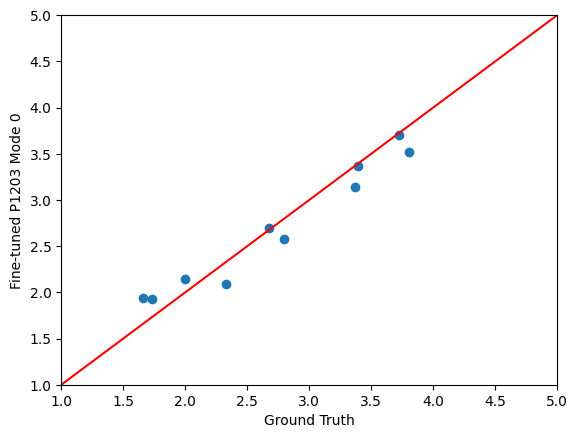

In [368]:
p1203_qoe_list = list(grouped_p1203_qoe['p1203_qoe'])
plt.scatter(ground_truth_qoe_list, p1203_qoe_list)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("Fine-tuned P1203 Mode 0")

Spearmann
              Ground truth    P.1203
Ground truth      1.000000  0.951515
P.1203            0.951515  1.000000
(2, 2)
0.9515151515151515


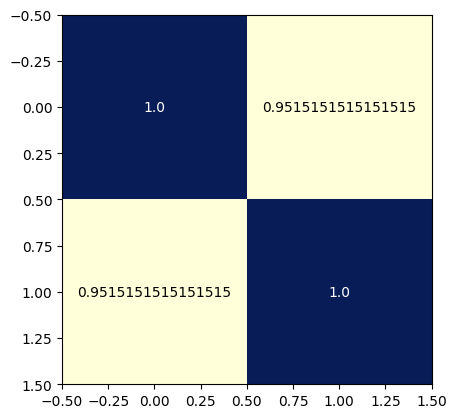

Pearson
              Ground truth    P.1203
Ground truth      1.000000  0.976858
P.1203            0.976858  1.000000


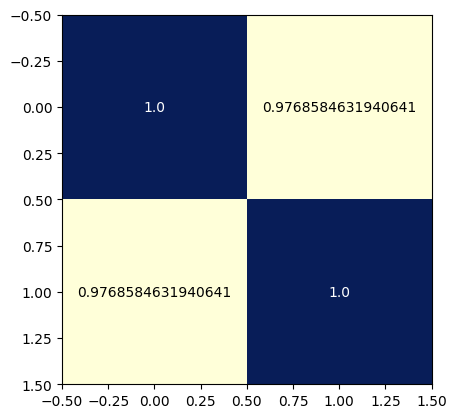

In [369]:
#import seaborn as sns

df_correlation = pd.DataFrame({
    "Ground truth": ground_truth_qoe_list,
    "P.1203": p1203_qoe_list
})

#corr_method = 'spearman'
#corr = df_correlation.corr(method=corr_method)
#sns.heatmap(corr, cmap='YlGnBu', annot = True)
#plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized.pdf')
#plt.show()

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)
print(spear_corr.shape)
print(spear_corr["Ground truth"]["P.1203"])

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_spearman_optimized.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_pearson_optimized.pdf")
plt.show()


In [370]:
# corr_method = 'pearson'
# corr = df_correlation.corr(method=corr_method)
# sns.heatmap(corr, cmap='YlGnBu', annot = True)
# plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized.pdf')
# plt.show()

In [371]:
#==============================================================================================================================
#VALIDATING with ReadyForWinter and FlowerDance

In [372]:
#coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}

qoe_p1203_dict = calculate_p1203(coeffs)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance'])]
                                # & ((qoe_p1203_df['qual'].isin(['r01']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_validation = qoe_p1203_df.groupby(['object', 'qual']).mean()
qoe_validation

bitrate  p1203_qoe
object         qual                    
FlowerDance    r01      2.66   1.943050
               r02      4.24   2.168957
               r03      7.12   2.710890
               r04     22.81   3.413164
               r05     39.35   3.753369
ReadyForWinter r01      1.97   1.944674
               r02      2.58   2.107125
               r03      3.61   2.591775
               r04      9.34   3.211608
               r05     16.59   3.571500

In [373]:
# Get ground truth qoe for these sequences
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['ReadyForWinter', 'FlowerDance'])]
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'qual']).aggregate(lambda x: tuple(x))
ground_truth_qoe_grouped_df

rate_scaled
object         qual                                                   
FlowerDance    r01   (1, 3, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, ...
               r02   (1, 3, 2, 2, 3, 3, 2, 1, 2, 2, 3, 3, 1, 3, 2, ...
               r03   (2, 4, 3, 2, 4, 3, 3, 3, 2, 2, 3, 3, 2, 3, 4, ...
               r04   (3, 4, 2, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, ...
               r05   (3, 5, 3, 3, 5, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, ...
ReadyForWinter r01   (1, 2, 2, 1, 2, 3, 1, 2, 1, 1, 2, 2, 1, 3, 1, ...
               r02   (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
               r03   (3, 3, 1, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 4, ...
               r04   (3, 4, 2, 3, 3, 3, 3, 4, 2, 4, 4, 4, 3, 3, 5, ...
               r05   (3, 4, 2, 4, 5, 4, 3, 4, 3, 3, 3, 4, 3, 4, 5, ...

In [374]:
calculate_rmse(qoe_validation, ground_truth_qoe_grouped_df)

np.float64(0.6739769891404065)

In [375]:
ground_truth_list = list(ground_truth_qoe_df.groupby(['object', 'qual']).mean()['rate_scaled'])
qoe_validation_list = list(qoe_validation['p1203_qoe'])
ground_truth_list

[1.7317073170731707,
 2.325,
 2.7948717948717947,
 3.3658536585365852,
 3.8048780487804876,
 1.6585365853658536,
 2.0,
 2.675,
 3.3902439024390243,
 3.725]

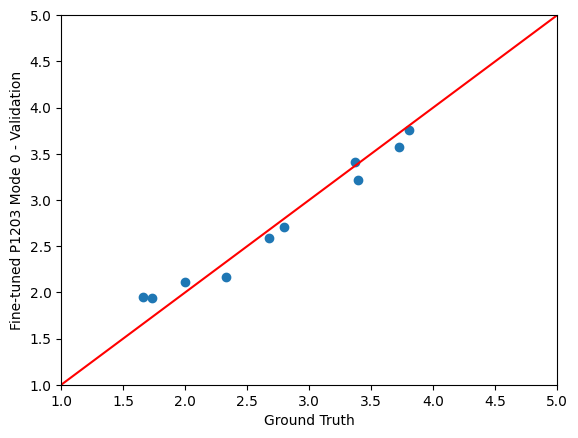

In [376]:
plt.scatter(ground_truth_list, qoe_validation_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Fine-tuned P1203 Mode 0 - Validation')
plt.show()

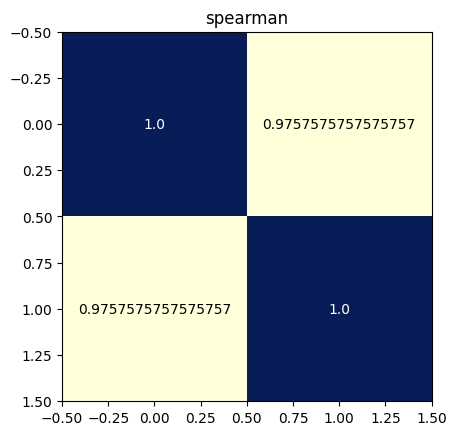

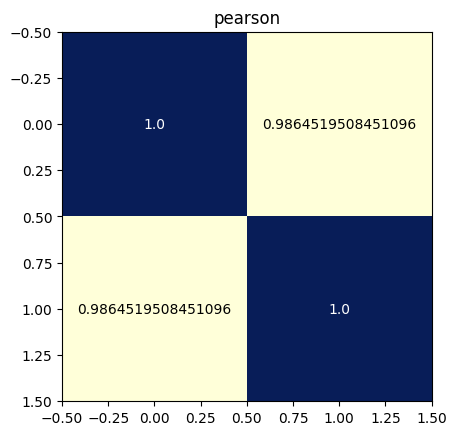

In [377]:
corr_method = 'spearman'
corr_df = pd.DataFrame({
    'Fine-tuned P1203': qoe_validation_list,
    'Ground truth': ground_truth_list
})

corr_methods = ['spearman', 'pearson']

for corr_method in corr_methods:
    corr = corr_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot = True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Fine-tuned P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Fine-tuned P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Fine-tuned P1203']['Fine-tuned P1203'], ha = "center", va = "center", color = "w")

    plt.savefig('./figures/correlation_heatmap_' + corr_method + '_validation.pdf')
    plt.title(corr_method)
    plt.show()

In [378]:
# original P1203
_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

qoe_p1203_dict = calculate_p1203(_COEFFS)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance'])]
                                #  & 
                                # ((qoe_p1203_df['start_quality'].isin(['r1']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_original_p1203 = qoe_p1203_df.groupby(['object', 'qual']).mean()
qoe_original_p1203

bitrate  p1203_qoe
object         qual                    
FlowerDance    r01      2.66   3.367212
               r02      4.24   4.185910
               r03      7.12   4.837059
               r04     22.81   4.886327
               r05     39.35   4.895940
ReadyForWinter r01      1.97   3.274671
               r02      2.58   4.036941
               r03      3.61   4.772641
               r04      9.34   4.865316
               r05     16.59   4.895940

In [379]:
print(calculate_rmse(qoe_original_p1203, ground_truth_qoe_grouped_df))
qoe_original_p1203_list = list(qoe_original_p1203['p1203_qoe'])

1.7974622597737144


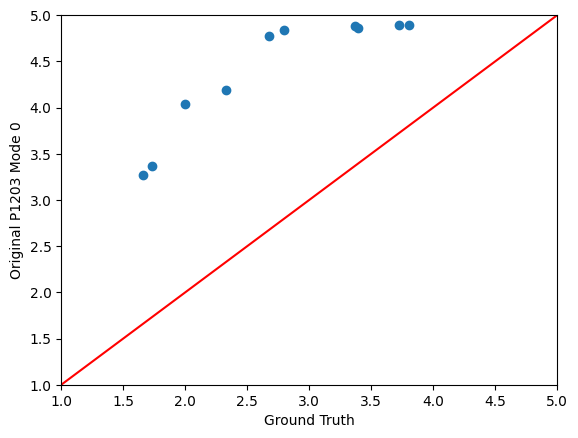

In [380]:
plt.scatter(ground_truth_list, qoe_original_p1203_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Original P1203 Mode 0')
plt.show()

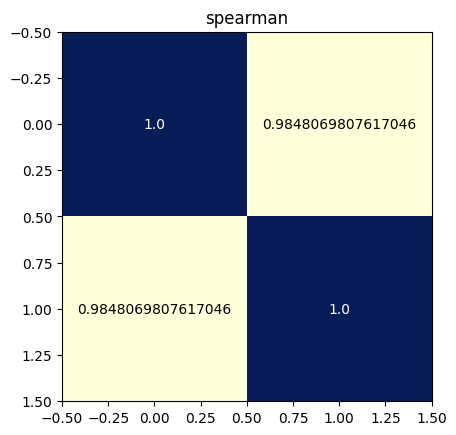

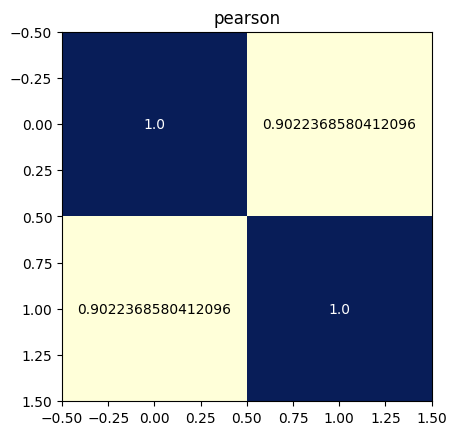

In [381]:
corr_all_df = pd.DataFrame({
    "Ground truth": ground_truth_list,
    # "Fine-tuned P1203": qoe_validation_list,
    "Original P1203": qoe_original_p1203_list
})

corr_methods = ['spearman', 'pearson']
for corr_method in corr_methods:
    corr = corr_all_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot=True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Original P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Original P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Original P1203']['Original P1203'], ha = "center", va = "center", color = "w")
    
    plt.title(corr_method)
    plt.show()

# Point cloud density

In [382]:
import numpy as np
import open3d as o3d

ModuleNotFoundError: No module named 'open3d'

In [ ]:
"""
Provides methods for calculating point cloud densities.
All methods can handle instances of PLYObject or list or ndarray instances of lists of vertices.
"""

import numpy as np
import scipy.spatial

def getRealDensityFromPlane(ply, planeParams):
	"""
	Calculates the point density from a given PLY plane object (or array of vertices).

	For calculating the correct point density, the given plane object will be z-aligned.
	For this process, the fitted plane parameters need to be specified. If the passed
	object is a PLYObject instance and has a fitPlane method, you can set planeParams to
	None. The plane fitting will then be done automatically.

	:param ply: Instance of PLYObject or list of vertices. If passed as ndarray (or list), a (N,3) array is expected.
	:param planeParams: Tuple of plane params fitted to the vertices. Set to None if the first parameter is a PLYObject instance and let the plane fitting run automatically.

	:returns: Point density for the given plane. The unit is depending on the unit of the passed vertices.
	"""

	if planeParams is None:
		fitPlaneMethod = getattr(ply, 'fitPlane', None)

		if callable(fitPlaneMethod):
			planeParams = fitPlaneMethod()
		else:
			raise ValueError('No plane parameters given and unable to fit plane to vertices')
	elif len(planeParams) != 4:
		raise ValueError('Invalid number of values for plane parameters')

	vertices = _getVertices(ply)

	zAxis = np.array([0.0, 0.0, 1.0])
	planeNormal = np.array(planeParams[:3])
	planeNormalLength = np.linalg.norm(planeNormal)
	unitPlaneNormal = planeNormal / planeNormalLength

	vec = planeNormal / planeNormalLength**2

	# A = unitPlaneNormal
	# B = zAxis

	# Shift plane to origin
	vertices += vec

	# Find roation aligning the plane normal vector to Z axis
	vecDot = unitPlaneNormal.dot(zAxis)
	vecCross = np.cross(zAxis, unitPlaneNormal)
	vecCrossNorm = np.linalg.norm(vecCross)

	G = np.array([[vecDot, -1 * vecCrossNorm, 0], [vecCrossNorm, vecDot, 0], [0, 0, 1]])

	u = unitPlaneNormal
	v = (zAxis - vecDot * unitPlaneNormal) / np.linalg.norm(zAxis - vecDot * unitPlaneNormal)
	w = vecCross
	Finv = np.column_stack([u, v, w])

	U = Finv.dot(G.dot(np.linalg.inv(Finv)))

	# Apply rotation to vertices to align them with axis
	vertices = U.dot(vertices.T).T

	# Use naiv method to get density
	hull = scipy.spatial.ConvexHull(vertices[:, :2])

	# Note: As the hull was calculated in 2D space,
	# the hull 'volume' is actually the surface area.
	return vertices.shape[0] / hull.volume

def getNaivDensityFromPlane(ply, alignedAxis=2):
	"""
	Calculates the point density a given PLY plane object (or array of vertices) assuming the plane is nearly aligned to a given axis.

	The vertices are simply projected on the coordinate plane they are nearly aligned to.
	This should give a good estimation of the point density.

	:param ply: Instance of PLYObject or list of vertices. If passed as ndarray (or list), a (N,3) array is expected.
	:param alignedAxis: The axis the plane object is nearly perpendicular to. Coordinates for this axis will be set to 0.

	:returns: Point density for the given plane. The unit is depending on the unit of the passed vertices.
	"""

	idx = np.array([0, 1, 2])
	idx = idx[idx != alignedAxis]
	v = _getVertices(ply)
	v = v[:, idx]

	hull = scipy.spatial.ConvexHull(v)

	# Note: As the hull was calculated in 2D space,
	# the hull 'volume' is actually the surface area.
	return v.shape[0] / hull.volume

def getRealDensityFromObject(ply):
	"""
	Calculates the point density a given PLY object (or array of vertices).

	:param ply: Instance of PLYObject or list of vertices. If passed as ndarray (or list), a (N,d) array is expected. N is the number of points, d is the dimensionality.

	:returns: Point density for the given object. The unit is depending on the unit of the passed vertices.
	"""
	vertices = _getVertices(ply)
	hull = scipy.spatial.ConvexHull(vertices)

	# Note: As the hull was calculated in 2D space,
	# the hull 'volume' is actually the surface area.
	return vertices.shape[0] / hull.volume

def _getVertices(ply):
	getVerticesMethod = getattr(ply, 'getVertices', None)

	if callable(getVerticesMethod):
		vertices = getVerticesMethod().T
	elif isinstance(ply, np.ndarray):
		vertices = ply
	else:
		vertices = np.array(ply)

	# print("==> {}".format(vertices))

	if len(vertices.shape) != 2 or vertices.shape[1] != 3:
		raise ValueError('Invalid number of dimensions (transpose necesary?)')

	return vertices

In [ ]:
ply_file_root = '/Users/minhkstn/Downloads/BlueSpin_r0'
for i in np.arange(1,6):
    ply_file = ply_file_root + str(i) + '_0000.ply'
    pcd = o3d.io.read_point_cloud(ply_file)
    density = getRealDensityFromObject(pcd.points)

    print("quality {}: {}".format(i, density))

In [ ]:
from plyfile import PlyData, PlyElement
ply_file = '/Users/minhkstn/Downloads/binary_BlueSpin_dec_0000.ply'
# f_out = open("/Users/minhkstn/Downloads/BlueSpin_dec_0000.ply", 'w+')

# f_in = open(ply_file, 'r')

# data = PlyData.read(f_in)
# data.text = True
# data.write(f_out)
# f_in.close()
# f_out.close()

In [ ]:
data = PlyData.read(ply_file)
data.text = True
data.comments = data.comments + ['original path: somefile.ply']
data.write('newfile.ply')

In [ ]:
pcd = o3d.io.read_point_cloud('newfile.ply')
getRealDensityFromObject(pcd.points)

In [ ]:
print(np.asarray(pcd.points))

In [ ]:
# AllPoints = np.asarray(pcd.points)
# R = 100; 
# density = []
# for i in range(len(AllPoints)):
#     distances = []
#     centroid = AllPoints[i]
#     distances.append(np.linalg.norm(centroid - AllPoints, axis=1))
#     # print(distances[-1])
#     density.append(sum(i < R for i in distances[-1]) - 1)
# density

In [ ]:
import os
rootpath = '/home/shared2/spirit/subjective_test/raw_data/UVG-VPC/vpcc'
videos = ['BlueSpin', 'FlowerDance', 'HelloGoodbye', 'ReadyForWinter']
rates = ['r01-dec', 'r02-dec', 'r03-dec', 'r04-dec', 'r05-dec']
mypaths = [os.path.join(rootpath, video, rate) for video in videos for rate in rates]
mypaths

In [ ]:
rootpath = '/home/shared2/spirit/subjective_test/raw_data/UVG-VPC/vpcc'
videos = ['BlueSpin', 'FlowerDance', 'HelloGoodbye', 'ReadyForWinter']
rates = ['r01-dec/', 'r02-dec/', 'r03-dec/', 'r04-dec/', 'r05-dec/']
# mypaths = [os.path.join(rootpath, video, rate) for video in videos for rate in rates]

for video in videos:
    firstpath = os.path.join(rootpath, video) 
    mypaths = [os.path.join(firstpath, rate) for rate in rates]
    for mypath in mypaths:

        folderToMake = "-binary"
        pathToMake = os.path.join(firstpath, mypath.split('/')[-2] + folderToMake)
        print(pathToMake)